In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
import networkx as nx
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import MultiLabelBinarizer
from os import listdir
from os.path import isfile, join
from PIL import Image
import pickle

In [2]:
# NUMBER_NODES = 9
NUMBER_NODES = 7
# NUMBER_NODES = 5

def load_data():
    train_ds = tf.keras.utils.image_dataset_from_directory(
        f'./train_adj_matrix_band_{NUMBER_NODES}',
        seed=123,
        image_size=(32, 32),
        batch_size=32)
    val_ds = tf.keras.utils.image_dataset_from_directory(
        f'./test_adj_matrix_band_{NUMBER_NODES}/test_images',
        seed=123,
        image_size=(32, 32),
        batch_size=32)
    return train_ds, val_ds

In [3]:
train_ds, val_ds = load_data()

Found 981 files belonging to 7 classes.
Found 63 files belonging to 4 classes.


In [4]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(NUMBER_NODES, NUMBER_NODES, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

class_names = train_ds.class_names
num_classes = len(class_names)

# Save test_Data to use it in compareResults (output_band, optimal_band, reverse-cuthill-mckee_band)
# with open(os.path.join(os.path.abspath(''), 'class_names_band.pickle'), 'wb') as f:
#     pickle.dump(class_names, f, pickle.HIGHEST_PROTOCOL)

In [5]:
model = models.Sequential()
# model.add(data_augmentation)
model.add(layers.Rescaling(1./255))
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(NUMBER_NODES, NUMBER_NODES, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_classes)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=128,
)

Epoch 1/128


C:\Users\Felipe\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\util\dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


31/31 [==============================] - 2s 50ms/step - loss: 1.0114 - accuracy: 0.5943 - val_loss: 5.6093 - val_accuracy: 0.0000e+00
Epoch 2/128
31/31 [==============================] - 2s 45ms/step - loss: 0.6833 - accuracy: 0.7227 - val_loss: 6.5313 - val_accuracy: 0.0000e+00
Epoch 3/128
31/31 [==============================] - 2s 57ms/step - loss: 0.5159 - accuracy: 0.7829 - val_loss: 9.3477 - val_accuracy: 0.0000e+00
Epoch 4/128
31/31 [==============================] - 2s 46ms/step - loss: 0.4202 - accuracy: 0.8298 - val_loss: 8.3485 - val_accuracy: 0.0000e+00
Epoch 5/128
31/31 [==============================] - 1s 44ms/step - loss: 0.3663 - accuracy: 0.8379 - val_loss: 8.1058 - val_accuracy: 0.0000e+00
Epoch 6/128
31/31 [==============================] - 1s 44ms/step - loss: 0.3178 - accuracy: 0.8869 - val_loss: 10.4078 - val_accuracy: 0.0000e+00
Epoch 7/128
31/31 [==============================] - 1s 44ms/step - loss: 0.2756 - accuracy: 0.9021 - val_loss: 12.2382 - val_accuracy:

In [6]:
model.save('CNN_dir_band_model')

INFO:tensorflow:Assets written to: CNN_dir_band_model\assets


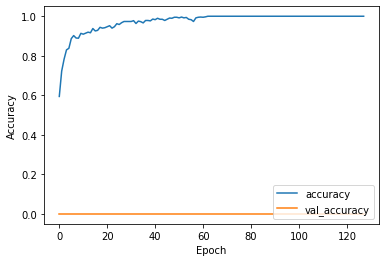

In [7]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

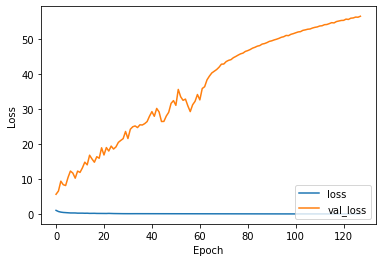

In [8]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [9]:
def get_bandwidth(Graph, nodelist):
    Graph = nx.Graph(Graph)
    if not Graph.edges:
        return 0
    L = nx.laplacian_matrix(Graph, nodelist=nodelist)
    x, y = np.nonzero(L)
    return (x-y).max()

def processDataToAdjImage(graphInput):
    adj = getGraph(graphInput)
    w, h = NUMBER_NODES, NUMBER_NODES
    data = np.zeros((h, w, 3), dtype=np.uint8)
    for i in range(len(adj)):
        for j in range(len(adj)):
            if adj[i, j] == 1:
                data[i, j] = np.array([255.0, 255.0, 255.0])
    # data /= 255.0
    img = Image.fromarray(data, 'RGB')
    resized = img.resize((32, 32), Image.NEAREST)
    image_input_np = np.array(resized)
    return image_input_np

def getGraph(upperTriangleAdjMatrix):
    dense_adj = np.zeros((NUMBER_NODES, NUMBER_NODES))
    dense_adj = np.zeros((NUMBER_NODES, NUMBER_NODES))
    k = 0
    for i in range(NUMBER_NODES):
        for j in range(NUMBER_NODES):
            if i == j:
                continue
            elif i < j:
                dense_adj[i][j] = upperTriangleAdjMatrix[k]
                k += 1
            else:
                dense_adj[i][j] = dense_adj[j][i]
    return dense_adj

In [10]:
def load_test_data():
    NUMBER_NODES=7
    df = pd.read_csv(f'./test_adj_matrix_band_{NUMBER_NODES}/test_{NUMBER_NODES}.csv')

    featuresNumber = ((NUMBER_NODES * NUMBER_NODES - NUMBER_NODES) // 2 )
    features = df.iloc[ : , : featuresNumber ].values
    labels = df.iloc[ : , featuresNumber : featuresNumber + 1 ].values # get only bandwidth value
    return features, labels

In [11]:
test_features, test_labels = load_test_data()
print(test_features.shape)
print(test_labels.shape)

(63, 21)
(63, 1)


In [12]:
list_pred = []
list_true = []

for x, true in zip(test_features, test_labels):
    get_graph_adj_image_arr = processDataToAdjImage(x)
    pred = model.predict(np.array([get_graph_adj_image_arr]))

    pred_bandwidth = class_names[np.argmax(pred)]
    list_pred.append(int(pred_bandwidth))
    list_true.append(int(true))

In [14]:
from sklearn.metrics import accuracy_score
list_pred = np.array(list_pred)
list_true = np.array(list_true)
print(accuracy_score(list_true, list_pred))
print('Pred mean - ', list_pred.mean())
print('True mean - ', list_true.mean())

0.9047619047619048
Pred mean -  3.1904761904761907
True mean -  3.1904761904761907
